# CAB420, Clustering, Example 7: Evaluating Clustering Methods
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
How do we know when our clustering is correct? Or when one solution is better than another? To do this we need a way to evaluate the accuracy of our clustering methods. Before we go too far, it's important to state that it's not always possible to do this. To evaluate our clustering we need to know what it should look like, i.e. we need to have some ground truth labels for what the clusters actually are. Often you won't have this, or if you do other techniques (such as classification) may be more appropriate for your problem.

Assuming that we have ground truth, there are a lot of metrics that have been proposed to evaluate clustering accuracy incuding:
* Rand index
* F-measure
* Jaccard index
* Dice Index
* Fowlkes-Mallows Index
* Mutual Information (and Normalised Mutual Information)
* and many more.... ([wikipedia](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation) has a reasonable overview of these for those who are interested)

We're going to look at some metrics not on that list:
* Purity
* Completeness
* V-Measure

These have been chosen becuase they are quite useful, and quite easy to interperet and understand what is being measured.

## Too Long; Didn't Read:
* Every now and then, we'll have some ground truth information and want to evaluate how good our clustering is. We won't have this often, and when we do it may just be partial information.
* We can (sort of) consider there to be two types of errors in clustering: points for multiple identities being grouped into one cluster, and points for a single identify being split into multiple clusters.
* Based on these ideas, we can define cluster purity and completeness. 
  * Purity is how "pure" a cluster is. Essentially. given the dominant class of a cluster it measures how much "other stuff" is in that cluster. Idealy, we'd like our purity to be 100% (each cluster only contains one class of stuff).
  * Completeness is how much of the given (majority) class is in a cluster. Again, in an ideal world a given cluster would contain all of the class that it represents, and so would be 100%. When we have fragmentation (stuff distributed across multiple clusters) this drops.
* There is a trade off between these two measures - increasing one decreasees the other. This is the same that we see with classification performance where we trade-off false positives and false negatives.
* A combined measure of accuracy is the V-Measure, which is the harmonic mean of the two values. We can use this to find a "best" overall solutions. However depending on our application there may be a need to prioritise one error over the other, and so the V-measure may not be appropriate depending on what other criteria we have to consider.

In [1]:
from sklearn import datasets
import numpy
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.cluster import DBSCAN

## Part 1: Get Clustering 
We're going to use the fisheriris dataset for this example. This is another inbuilt dataset, and has some measurements for three types of Iris (the flower, not the part of the eye) alongside a label for what species the Iris is. The task is to cluster the data into the three species.

We'll use K-means and some different values of K and see what happens to our clusters.

Text(0.5, 1.0, 'Actual')

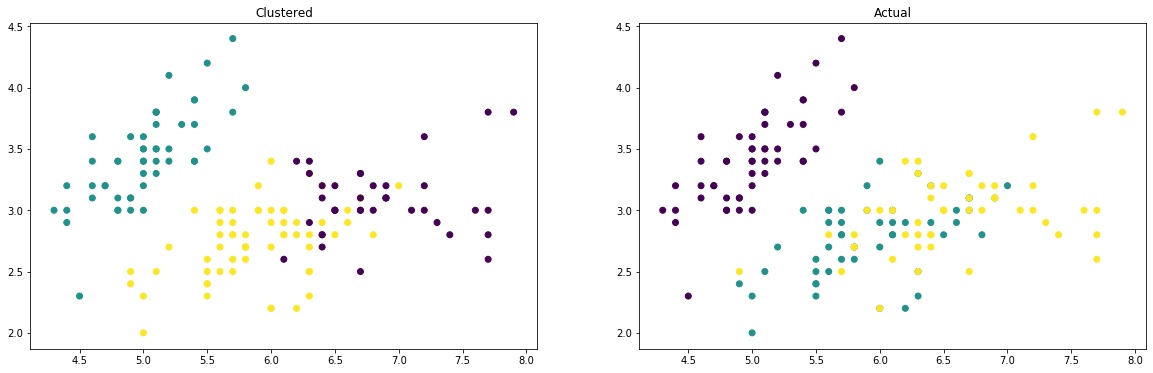

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
kmeans = KMeans(n_clusters=3, random_state=4).fit(X)
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_);
ax.set_title('Clustered')
ax = fig.add_subplot(1, 2, 2)
ax.scatter(X[:,0], X[:,1], c=y);
ax.set_title('Actual')

On first glance we'd perhaps say:
* Clustering is pretty good, predicted green lines up with actual purple. Predicted yellow maps to real green and predicted purple to real yellow.
* Perhaps some confusion between the predicted yellow and purple, but not too bad overall.

Before we compute our metrics, we can get a confusion matrix.

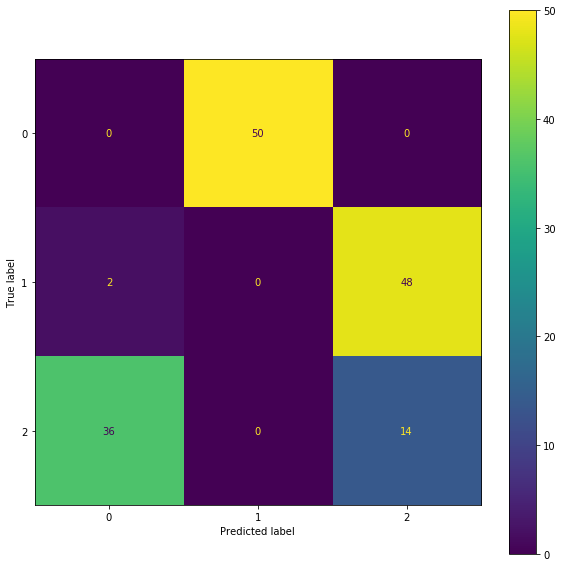

In [3]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
cm = confusion_matrix(y, kmeans.labels_)
c = ConfusionMatrixDisplay(cm, display_labels=range(3))
c.plot(ax = ax)    

Unlike when we've looked at these for classification, we can't rely on looking at the diagonal (true class 1 does not correspond to clustered class 1). Rather we can look at each row and column to understand fragmentation. If we consider the first row and second column, we can see that thre is no fragmentation for this class for example.

In terms of what this shows however, it really just backs up which we could see visually, but for more than three classes this sort of thing obviously becomes handy.

## Part 2: Metrics
### Purity
First up, let's start with purity. This is, as the name implies, how "pure" a cluster is. Ideally, we'd like each cluster to contain only instances of a single "true" class, so for example if a cluster has 20 things in it then all 20 should belong to the same ground truth class, and the purity would be 1.0. Purity is bounded [0..1]. We compute the purity for each of the predicted clusters. For a single cluster, we define purity as:

$p_{n} = max_{d \in D}\frac{|d \in n |}{|n|}$ 

where $p_{n}$ is the purity of the nth cluster, and $d$ is the ground truth cluster that has the most points in the cluster of interest, $n$.

We can then get the overall purity as the average (or weighted average) of the purity for each cluster.
Basically, for each of our created clusters we find the dominant class in that cluster, and then look at how much of that cluster is that dominant class. We can obtain a measure both overall, and for each cluster.

In another case of python to the rescue, we already have this implemented in sklearn, though it's termed homogeneity.

In [4]:
purity = homogeneity_score(y, kmeans.labels_)
print(purity)

0.7514854021988338


sklearn's implementation does not give us the purity of individual clusters (just the overall) - however usually it's the overall value that we care about.

### Completness
This is how "complete" a cluster is. In our ideal world again, if we have 20 instances of a class in the data, we'd like all of those to be in a single predicted cluster. Sometime this may also be termed fragmentation. The formula for completeness for a single cluster is

$c_{d} = max_{n \in N}\frac{|d \in n |}{|d|}$ 

This time, we look for the created cluster $n$, which has the largest number of elements from the ground truth cluster $d$ in it, and divde the size of the intersection of $n$ and $d$ by the cardinality of $d$. Again, we can take the aveage (or weighted average) of these to get the overall completeness.

There is one other key difference to purity. With purity, we get a purity value per cluster that we have created (i.e. if we have 3 ground truth clusters and we've clustered the data into 4, we can get a purity for each of the 4 clusters we created). With completeness, we can get a completeness value per ground truth cluster (so in the previous example with 3 ground truth clusters and 4 clusters we created, we can get the completeness for the 3 ground truth clusters). Again with python, this not such an issue as we only get the single overall value.

In [5]:
completeness = completeness_score(y, kmeans.labels_)
print(completeness)

0.7649861514489815


### V-Measure
Finally, we have the v-measure, which is the harmonic mean of purity and completeness. Basically, this is trying to combine the two measures into one single value, like this:

$V = \frac{2*p*c}{p+c}$

In [6]:
vmeasure = v_measure_score(y, kmeans.labels_)
print(vmeasure)

0.7581756800057784


## Part 3: Metric Values as K Changes
At this point, the obvious thing to do is start changing K and see what happens. In general, there is a trade off between purity and completeness: as one increases the other will decrease. Let' look a few different values of K and see how things change. 

We'll start with 2.

Purity:       0.5223224641010155
Completeness: 0.8835142349190769
V-Measures:   0.6565191143081123


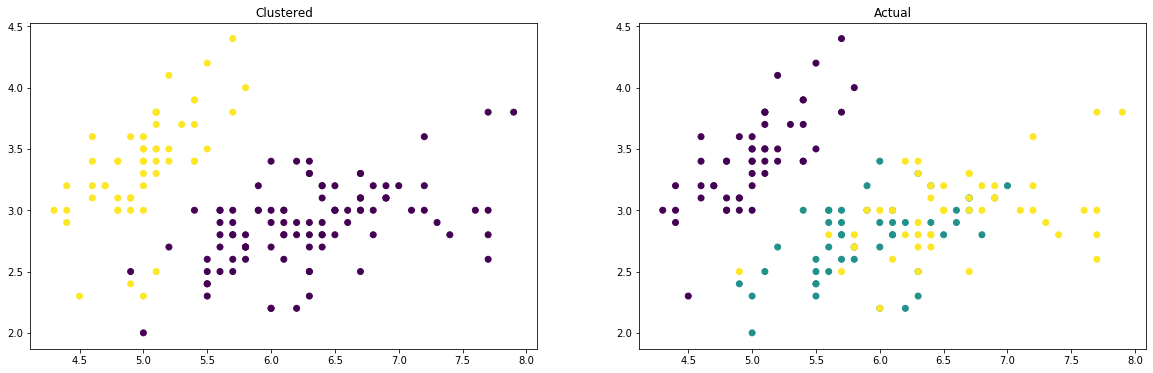

In [7]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
kmeans = KMeans(n_clusters=2, random_state=4).fit(X)
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_);
ax.set_title('Clustered')
ax = fig.add_subplot(1, 2, 2)
ax.scatter(X[:,0], X[:,1], c=y);
ax.set_title('Actual')
purity = homogeneity_score(y, kmeans.labels_)
print('Purity:       ' + str(purity))
completeness = completeness_score(y, kmeans.labels_)
print('Completeness: ' + str(completeness))
vmeasure = v_measure_score(y, kmeans.labels_)
print('V-Measures:   ' + str(vmeasure))

And then try 5

Purity:       0.8309376027605745
Completeness: 0.6016503137916493
V-Measures:   0.6979451155016857


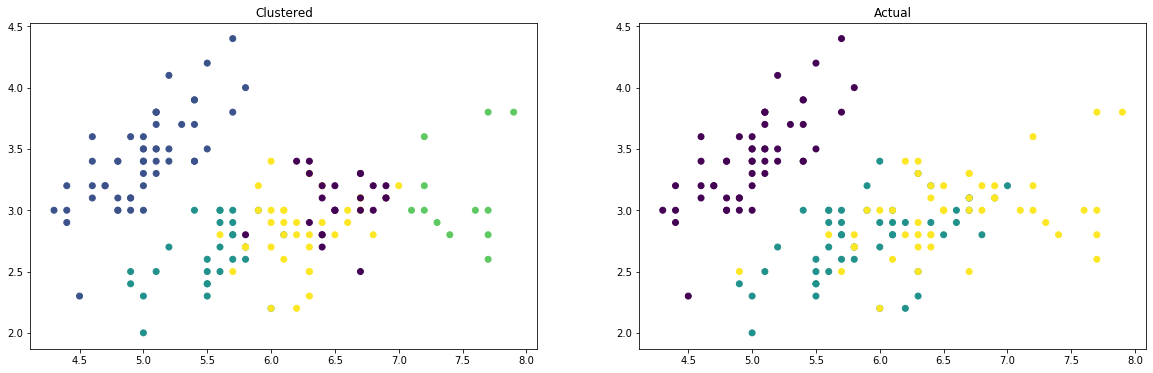

In [8]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
kmeans = KMeans(n_clusters=5, random_state=4).fit(X)
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_);
ax.set_title('Clustered')
ax = fig.add_subplot(1, 2, 2)
ax.scatter(X[:,0], X[:,1], c=y);
ax.set_title('Actual')
purity = homogeneity_score(y, kmeans.labels_)
print('Purity:       ' + str(purity))
completeness = completeness_score(y, kmeans.labels_)
print('Completeness: ' + str(completeness))
vmeasure = v_measure_score(y, kmeans.labels_)
print('V-Measures:   ' + str(vmeasure))

And 10.

Purity:       0.9266929334329798
Completeness: 0.46381684069697
V-Measures:   0.618213257724176


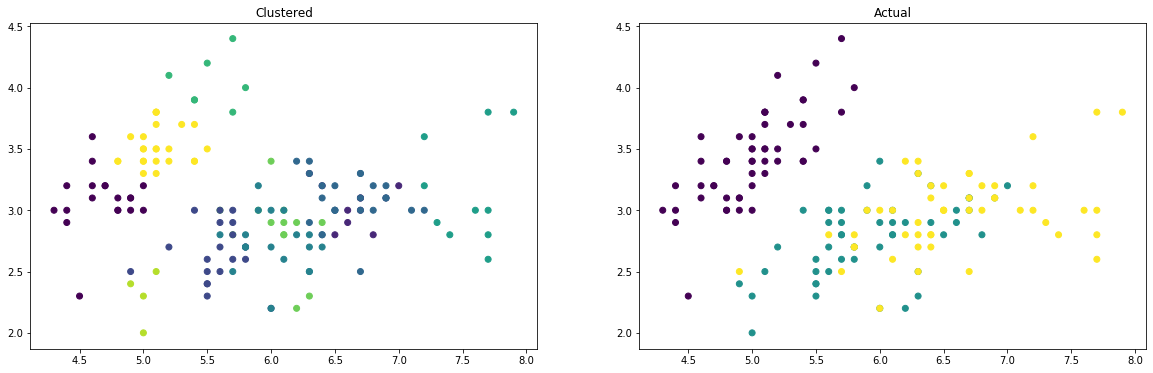

In [9]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
kmeans = KMeans(n_clusters=10, random_state=4).fit(X)
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_);
ax.set_title('Clustered')
ax = fig.add_subplot(1, 2, 2)
ax.scatter(X[:,0], X[:,1], c=y);
ax.set_title('Actual')
purity = homogeneity_score(y, kmeans.labels_)
print('Purity:       ' + str(purity))
completeness = completeness_score(y, kmeans.labels_)
print('Completeness: ' + str(completeness))
vmeasure = v_measure_score(y, kmeans.labels_)
print('V-Measures:   ' + str(vmeasure))

While this data is a bit simple in some respects, it does show some characteristics of these measures:
* When we undercluster (fewer clusters than the true number, i.e. K=2) our completeness will increase, and our purity will drop off as instances of different classes are forced together
* When we overclsuter (more clusters than the true number, i.e. K=5, K=10) our purity will increase, and completeness will drop off. Each "true cluster" is now split into more and more small groups, forcing completeness down. At the same time, it is easier to separate instances as we have more groups, and so we have a higher purity.

We can look at this en-masse too.

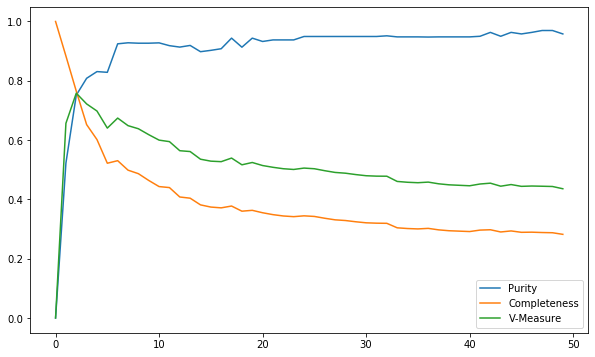

In [10]:
pvec = []
cvec = []
vvec = []
for i in range(50):
    kmeans = KMeans(n_clusters=(i+1), random_state=4).fit(X)
    purity = homogeneity_score(y, kmeans.labels_)
    completeness = completeness_score(y, kmeans.labels_)
    vmeasure = v_measure_score(y, kmeans.labels_)
    
    pvec.append(purity)
    cvec.append(completeness)
    vvec.append(vmeasure)
    
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(pvec, label='Purity')
ax.plot(cvec, label='Completeness')
ax.plot(vvec, label='V-Measure')
ax.legend()

We can see our V-Measure peaks at K=3 (i.e. the true number of clusters). 